In [48]:
import numpy as np
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import os


In [30]:
# Single API endpoint providing all years' budget data
api_endpoint = 'http://127.0.0.1:5000/api/v1.0/categories_exp'

# Fetch the data from the API
response = requests.get(api_endpoint)
response.raise_for_status()  # This will raise an exception for HTTP errors if any occur
data = response.json()

# Convert the JSON data to a DataFrame
# Assuming the JSON data includes a 'Year' field in each record
df = pd.DataFrame(data)

# Print the first few rows to verify data structure
print(df.head())


                            Category Name  Expense 2019(millions)  \
0                 Contribution To Capital                  343.45   
1                      Other Expenditures                 2711.14   
2                        Service And Rent                 2082.85   
3                Inter-Divisional Charges                  316.15   
4  Contribution To Reserves/Reserve Funds                 1374.33   

   Expense 2020(millions)  Expense 2021(millions)  Expense 2022(millions)  \
0                  343.46                  349.54                  347.76   
1                 2611.53                 2835.06                 2776.24   
2                 2178.26                 2342.04                 2632.93   
3                  156.99                    0.00                  312.48   
4                 1492.21                 1569.50                  679.06   

   Expense 2023(millions)                       _id  
0                  345.49  65e8e0a4e41cefb14c821795  
1             

In [31]:
# Select relevant numeric features for clustering
# You may need to exclude non-relevant columns such as IDs or descriptive text
features = df.select_dtypes(include=[np.number])  # This selects only numeric columns

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean of each column
features = imputer.fit_transform(features)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/Users/muskanmittal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


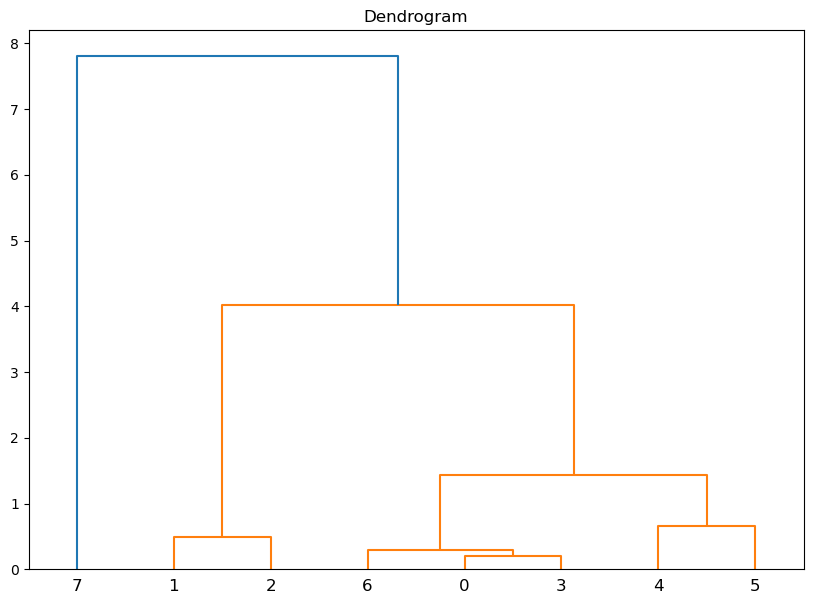

In [32]:
# Perform the clustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(features_scaled)

# Optionally, plot a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(features_scaled, method='ward'))
plt.show()

In [60]:
# Assuming 'features_scaled' is your dataset ready for clustering
import pickle

num_samples = features_scaled.shape[0]
max_clusters = min(num_samples - 1, 10)  # Ensuring we do not attempt too many clusters

for n_clusters in range(2, max_clusters + 1):  # Ensure at least two clusters
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    filename = f"cluster_models/cluster_model_Cluster{n_clusters}"
    with open(filename, "wb") as file:
        pickle.dump(clusterer, file)

    # Calculate and print the silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.6299073468472868
For n_clusters = 3 The average silhouette_score is : 0.621592895636224
For n_clusters = 4 The average silhouette_score is : 0.5157272899964427
For n_clusters = 5 The average silhouette_score is : 0.40412828753638264
For n_clusters = 6 The average silhouette_score is : 0.22706256201718622
For n_clusters = 7 The average silhouette_score is : 0.05247488933422703


In [34]:
# Fit the final model
final_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
final_labels = final_cluster.fit_predict(features_scaled)

# Add cluster labels to the original DataFrame
df['Cluster'] = final_labels

# Analyze clusters
for i in range(final_cluster.n_clusters):
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i} Summary:")
    print(cluster_data.describe())

Cluster 0 Summary:
       Expense 2019(millions)  Expense 2020(millions)  Expense 2021(millions)  \
count                 2.00000                2.000000                2.000000   
mean               2396.99500             2394.895000             2588.550000   
std                 444.26812              306.368155              348.617785   
min                2082.85000             2178.260000             2342.040000   
25%                2239.92250             2286.577500             2465.295000   
50%                2396.99500             2394.895000             2588.550000   
75%                2554.06750             2503.212500             2711.805000   
max                2711.14000             2611.530000             2835.060000   

       Expense 2022(millions)  Expense 2023(millions)  Cluster  
count                2.000000                 2.00000      2.0  
mean              2704.585000              3067.16000      0.0  
std                101.335473                 5.62857   

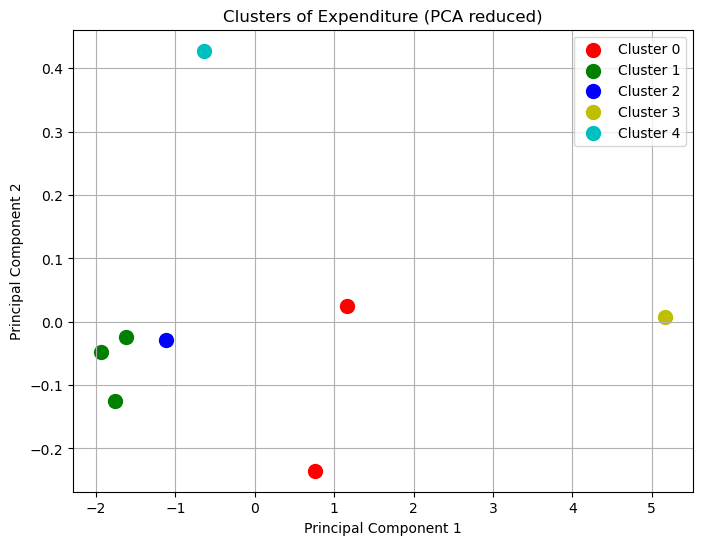

In [38]:
# Applying PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)  # Correct parameter for specifying number of principal components
principal_components = pca.fit_transform(features_scaled)

# Creating a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = final_labels  # Assuming 'final_labels' from your clustering results

# Plotting the clusters
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'brown']  # Extend color list if more than 10 clusters

for i in range(final_cluster.n_clusters):  # Assuming 'final_cluster' from your clustering results
    cluster_subset = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_subset['Principal Component 1'], cluster_subset['Principal Component 2'], s=100, c=colors[i], label=f'Cluster {i}')

plt.title('Clusters of Expenditure (PCA reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

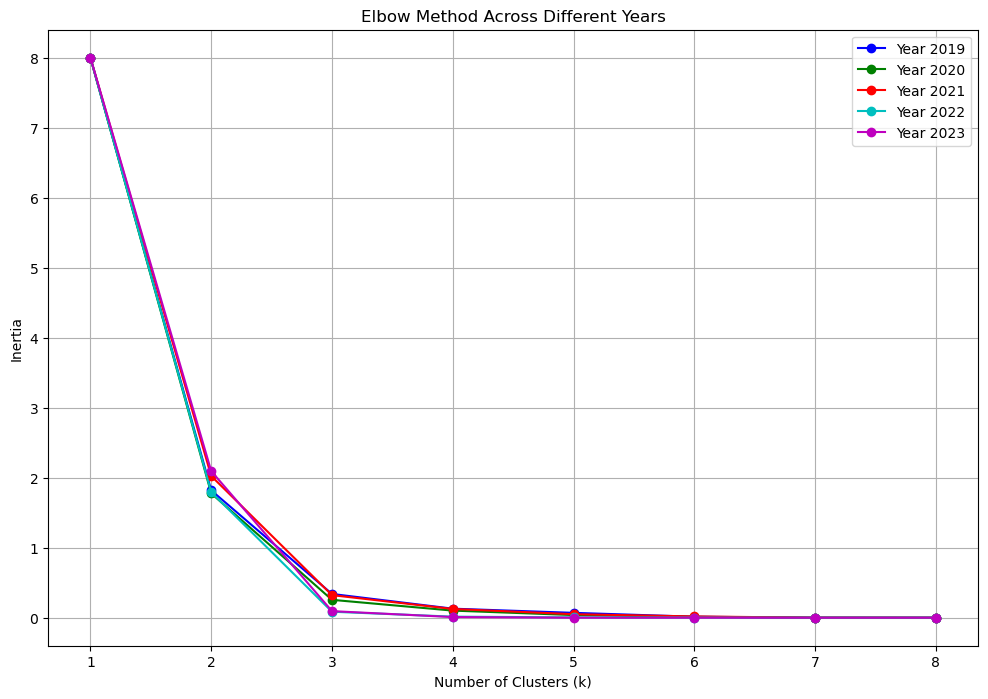

In [61]:
years = ['2019', '2020', '2021', '2022', '2023']
colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for different years

# Ensure data is scaled properly for each year
scaler = StandardScaler()

# Create a figure outside the loop to plot all years on the same graph
plt.figure(figsize=(12, 8))

for year, color in zip(years, colors):
    # Select the column for the current year and drop NA values
    current_year_data = df[f'Expense {year}(millions)'].dropna().values.reshape(-1, 1)
    if current_year_data.size == 0:
        print(f"No data available for year {year}. Skipping...")
        continue  # Skip this year if there is no data
    
    current_year_data_scaled = scaler.fit_transform(current_year_data)

    # Dynamically adjust the range of k based on the number of samples
    num_samples = len(current_year_data_scaled)
    max_k = min(num_samples, 10)  # Maximum number of clusters is the lesser of num_samples or 10

    inertias = []
    k_values = range(1, max_k + 1)  # Adjust range to ensure k does not exceed number of samples
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(current_year_data_scaled)
        inertias.append(kmeans.inertia_)

    # Plotting the inertia graph for each year on the same plot
    plt.plot(k_values, inertias, marker='o', color=color, label=f'Year {year}')

# Add labels, title, and legend to the plot
plt.title('Elbow Method Across Different Years')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)
plt.show()